## **<1D Flame Tabulation for Hydrogen Combustion Modeling>**

: This study investigates hydrogen-methane mixtures using Cantera. By varying the width and product temperature according to a fixed hydrogen ratio in the mixture, the velocity and strain rate of the mixture are adjusted. 

In [63]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d

p0 = 101325
T0 = 300
phi = 0.7 # equivalence ratio
alpha = 0.6
width = 0.02 # 2cm
loglevel = 0

xh2 = alpha / (1 - alpha) * 1
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

gas = ct.Solution('gri30.yaml')
gas.TP = T0, p0
gas.set_equivalence_ratio(phi, fuel, oxidizer)

### **- Calculate Laminar Flame Speed using FreeFlame Object**
: The `FreeFlame` object is used to calculate the **laminar flame speed** in a premixed flame.

In [56]:
flame = ct.FreeFlame(gas, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0] #Sl0
print(f'Flame speed: {flame_speed:.5f} m/s')

Flame speed: 0.34056 m/s


In [64]:
def get_adiabatic_temperature_from_flame(flame): # lamninar unstretched flame
    Tad = flame.T[-1]  # final status of the flame
    return Tad

Tad = get_adiabatic_temperature_from_flame(flame) # laminar unstretched configuration
print(f'Adiabatic temperature (Tad) from FreeFlame: {Tad:.2f} K')
Xflame = flame.X[:,-1]

Adiabatic temperature (Tad) from FreeFlame: 1820.61 K


### **- Thermal Diffusivity Equation**
: The thermal diffusivity $\alpha$ represents how quickly heat diffuses through a material.


$$
\alpha = \frac{\lambda}{\rho \, c_p}
$$

- $\alpha$: Thermal diffusivity
- $\lambda$: Thermal conductivity  
- $\rho$: Density  
- $c_p$: Specific heat at constant pressure  

In [65]:
cp = flame.cp_mass[0]
density = flame.density_mass[0]    
lambda_ = flame.thermal_conductivity[0]
thermal_diffusivity = lambda_ / (density * cp)

### **- Consumption Speed($S_{cF}$) Equation**
: The consumption speed $S_{cF}$ represents the consumption speed, which is determined by evaluating the net production rates of fuel species across the flame and normalizing them with the unburned mixture properties.

$$
S_{cF} = \frac{\sum_{k=1}^{N_f} \eta_k \int_{-\infty}^\infty \dot{\omega}_k \, dx}
{\rho_u \sum_{k=1}^{N_f} \eta_k \left( Y_{k,b} - Y_{k,u} \right)}
$$

- $S_{cF}$: Consumption speed  
- $N_f$: Number of fuel species  
- ${\eta}_k$: Weighting factor for species
- ${\omega}_k$: Net production rate of species
- ${\rho}_u$: Density of the unburned mixture
- $Y_{k,b}$: Mass fraction of species at the burned side  
- $Y_{k,u}$: Mass fraction of species at the unburned side  

In [58]:
def calculate_consumption_speed(flame_cf, gas, fuel_species):
    rho_u = flame_cf.density[0]
    total_fuel_mass_fraction = sum(flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)

    integral_numerator = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        nk = flame_cf.Y[i_fuel, 0] / total_fuel_mass_fraction
        integral = scipy.integrate.simpson(gas.molecular_weights[i_fuel] * flame_cf.net_production_rates[i_fuel], x=flame_cf.grid)
        integral_numerator += nk * integral

    mass_fraction_diff = sum(flame_cf.Y[gas.species_index(fuel), -1] - flame_cf.Y[gas.species_index(fuel), 0] for fuel in fuel_species)
    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    return S_cF

### **- Simulation of Strain Rate vs. Consumption Speed in Counterflow Premixed Flame**
: This code evaluates the **strain rate (Ka)** and **consumption speed (ScF)** for a counterflow premixed flame as the mass flow rate $\dot{m}$ varies. The results are used to analyze the behavior of premixed flames under different strain conditions.

1. **Mass Flow Rate Sweep** : The mass flow rate $\dot{m}$ is varied logarithmically from $10^{-2}$ to $10^{2}$ with 100 points.
   
2. **Counterflow Flame Setup** : A `CounterflowPremixedFlame` object is used to simulate the flame under counterflow conditions.  

3. **Strain Rate (Ka) Calculation** : The strain rate $K_a$ is computed using the maximum velocity gradient $\frac{du}{dx}$ in the flame.  
   
     $$
     K_a = \frac{\alpha}{S_{L0}} \cdot \max \left( \frac{du}{dx} \right)
     $$
     
5. **Consumption Speed (ScF) Calculation** : $S_{cF}$ is determined by integrating the net production rates of fuel species across the flame.

In [67]:
mdot_values = np.logspace(-2, 2, 100)  # From 0.01 to 100 with 100 points
Ka_values = []
ScF_values = []

# Loop through mdot values
for mdot in mdot_values:
    # Initialize gas object in each iteration to avoid carrying over previous states
    gas = ct.Solution('gri30.yaml')
    gas.TP = T0, p0
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    
    flame_cf = ct.CounterflowPremixedFlame(gas=gas, width=width)
    flame_cf.transport_model = 'multicomponent'
    flame_cf.energy_enabled = True
    flame.soret_enabled = True
    flame_cf.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)
    flame_cf.reactants.mdot = mdot
    flame_cf.products.mdot = mdot
    flame_cf.products.T = Tad  # no heat loss(beta=1)
    flame_cf.products.X = Xflame
    flame_cf.set_initial_guess(equilibrate=False)
    
    flame_cf.solve(loglevel, auto=True)

    # Update temperature for current mdot
    Tp = 1000
    
    # Calculate the maximum gradient |du/dx|
    grad_u = np.gradient(flame_cf.velocity, flame_cf.grid) 
    max_grad_idx = np.argmax(np.abs(grad_u))  # find max |du/dx| index
    max_grad_value = np.abs(grad_u[max_grad_idx])
    
    # Calculate strain rate (Ka)
    Ka = (thermal_diffusivity/flame_speed) / flame_speed * max_grad_value
    Ka_values.append(Ka)
    
    ScF = calculate_consumption_speed(flame_cf, gas, ['CH4', 'H2'])
    ScF_values.append(ScF)

In [68]:
y_values = []
for i in ScF_values:
    temp = i / flame_speed
    y_values.append(temp)

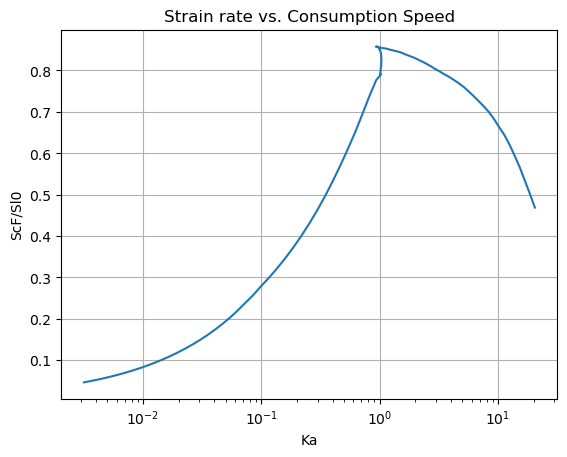

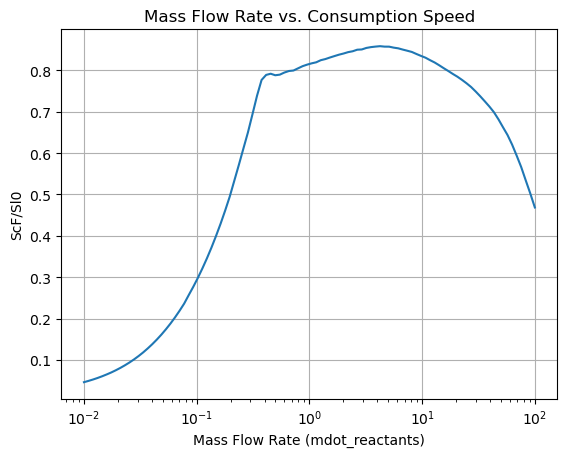

In [69]:
plt.plot(Ka_values, y_values)
plt.xscale('log')
plt.xlabel('Ka')
plt.ylabel('ScF/Sl0')
plt.title('Strain rate vs. Consumption Speed')
plt.grid(True)
plt.show()

plt.plot(mdot_values, y_values)
plt.xscale('log')
plt.xlabel('Mass Flow Rate (mdot_reactants)')
plt.ylabel('ScF/Sl0')
plt.title('Mass Flow Rate vs. Consumption Speed')
plt.grid(True)
plt.show()